<div style="width: 100%;text-align:right;display: flex; align-items: top;">
    <div style="float: left;width: 80%;text-align:left">
        <h1>From sunrise to sunset - Demo for benchmark data use <a class="tocSkip">&#182;</a></h1>
        <p><em><a href="mailto:alexander.dunkel@tu-dresden.de">Alexander Dunkel</a>, Institute of Cartography, TU Dresden</em></p></div>
    <div style="width:256px;text-align:right;margin-top:0px;margin-right:10px"><a href="https://gitlab.hrz.tu-chemnitz.de/tud-ifk/sunsetsunrise-example-benchmarkdata"><img src="https://kartographie.geo.tu-dresden.de/ad/sunsetsunrise-demo/version.svg"></a></div>
</div>

In [3]:
from IPython.display import Markdown as md
from datetime import date

today = date.today()
with open('/.version', 'r') as file: app_version = file.read().split("'")[1]
md(f"Last updated: {today.strftime('%b-%d-%Y')}, [Carto-Lab Docker](https://gitlab.vgiscience.de/lbsn/tools/jupyterlab) Version {app_version}")

Last updated: Feb-22-2023, [Carto-Lab Docker](https://gitlab.vgiscience.de/lbsn/tools/jupyterlab) Version 0.12.3

This notebook demonstrates how to load and use the HyperLogLog benchmark data shared in

> Dunkel, A., Hartmann, M. C., Hauthal, E., Burghardt, Dirk, & Purves, R. S. (2023).
> From sunrise to sunset: Exploring landscape preference through global reactions to
> ephemeral events captured in georeferenced social media. PLoS ONE, 17(1). [DOI](https://doi.org/10.1371/journal.pone.0280423)

The data is available in a [repository](https://doi.org/10.25532/OPARA-200)

<div class="alert alert-success" role="alert" style="color: black;">
    <details><summary style="cursor: pointer;"><strong>Unfamiliar with HLL?</strong></summary>
    <ul>
        <li>A basic introduction to working with HLL data is provided <a href="https://kartographie.geo.tu-dresden.de/python_datascience_course/02_hll_intro.html">in this jupyter notebook</a></li>
        <li>The scoping study for the sunset-sunrise paper was based on the Flickr YFCC 100M dataset, and the corresponding notebooks can be found <a href="https://gitlab.vgiscience.de/ad/yfcc_gridagg">here</a></li>
        <li>The notebooks for the sunset-sunrise article can be found <a href="https://gitlab.vgiscience.de/ad/sunset-sunrise-paper">here</a></li>
    </ul>
    </details>
</div>

## Prepare environment

To run this notebook, as a starting point, you have two options:

<div class="alert alert-info" role="alert" style="color: black;">
    <details><summary style="cursor: pointer;"><strong>1.</strong> Create an environment with the packages and versions shown in the following cell.</summary>
        As a starting point, you may use the latest conda <a href="https://gitlab.vgiscience.de/lbsn/tools/jupyterlab/-/blob/master-latest/environment_default.yml">environment_default.yml</a> from our CartoLab docker container.
    </details>
</div>

<div class="alert alert-info" role="alert" style="color: black;">
    <details><summary style="cursor: pointer;"><strong>2.</strong> If docker is available to to, we suggest to use the <a href="https://gitlab.vgiscience.de/lbsn/tools/jupyterlab">Carto-Lab Docker Container</a></summary>

Clone the repository and edit your <code>.env</code> value to point to the repsitory, where this notebook can be found, e.g.:
        
```bash
git clone https://gitlab.vgiscience.de/lbsn/tools/jupyterlab.git
cd jupyterlab
cp .env.example .env
nano .env
## Enter:
# JUPYTER_NOTEBOOKS=~/notebooks/sunsetsunrise-demo
# TAG=v0.12.3
docker network create lbsn-network
docker-compose pull && docker-compose up -d
```

We also use <a href="https://gitlab.vgiscience.de/lbsn/databases/pg-hll-empty">pg-hll-empty</a> Postgresql as a backend, to work with the HyperLogLog data. 
You _can_ use the python package <a href="https://github.com/AdRoll/python-hll">python-hll</a> instead (which is included in the Carto-Lab Docker container), 
but it will be slower than the native <a href="https://github.com/citusdata/postgresql-hll">postgresql-hll</a> implementation. To pull <code>pg-hll-empty</code> and 
add to the same docker network:

```bash
git clone https://gitlab.vgiscience.de/lbsn/databases/pg-hll-empty.git
cd pg-hll-empty
cp vars.env.example vars.env
nano vars.env
# optionally adjust READONLY_USER_PASSWORD
docker-compose up -d
```

</details>
</div>

In [4]:
import sys
from pathlib import Path

module_path = str(Path.cwd().parents[0] / "py")
if module_path not in sys.path:
    sys.path.append(module_path)
from modules import tools

root_packages = [
    'python', 'colorcet', 'holoviews', 'ipywidgets', 'geoviews', 'hvplot',
    'geopandas', 'mapclassify', 'memory_profiler', 'python-dotenv', 'shapely',
    'matplotlib', 'sklearn', 'numpy', 'pandas', 'bokeh', 'fiona',
    'matplotlib-venn', 'xarray']
tools.package_report(root_packages)

Load dependencies:

In [5]:
import os
import psycopg2 # Postgres API
import geopandas as gp
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict, Optional
from pyproj import Transformer, CRS, Proj
from IPython.display import clear_output, display, HTML

Activate autoreload of changed python files:

In [6]:
%load_ext autoreload
%autoreload 2

### Parameters

Define initial parameters that affect processing

In [7]:
WORK_DIR = Path.cwd().parents[0] / "tmp"
"""Working diretcory"""
EPSG_CODE = 54009
CRS_PROJ = f"esri:{EPSG_CODE}"
"""Target projection: Mollweide (epsg code).
note: Mollweide defined by _esri_
in epsg.io's database"""
CRS_WGS = "epsg:4326"
"""Input projection (Web Mercator)"""
OUTPUT = Path.cwd().parents[0] / "out"
"""Define path to output directory (figures etc.)""";

In [8]:
WORK_DIR.mkdir(exist_ok=True)

### Load benchmark data

In [9]:
source_zip="https://opara.zih.tu-dresden.de/xmlui/bitstream/handle/123456789/5793/S10.zip?sequence=1&isAllowed=y"

In [10]:
if not (WORK_DIR / "flickr-all.csv").exists():
    tools.get_zip_extract(uri=source_zip, filename="S10.zip", output_path=WORK_DIR)

Show the directory tree:

In [11]:
tools.tree(Path.cwd().parents[0])

### Load data

In [12]:
ALL_FLICKR = WORK_DIR / "flickr_all_hll.csv"

In [13]:
dtypes = {'latitude': float, 'longitude': float}

In [14]:
df = pd.read_csv(ALL_FLICKR, dtype=dtypes, encoding='utf-8')

In [15]:
df.head()

latitude   longitude                                           user_hll
0  0.040050 -179.750586  \x138b400e0116e13ec2414152615441a6a1b206c544e3...
1 -0.364335 -179.752800                                       \x138b40cbe1
2 -0.768727 -179.760539                                       \x138b407ee3
3  0.848830 -177.767038                                       \x138b406641
4 -0.364335 -177.757221                                       \x138b4039c1

### Test HLL

First, let's test the slower Python implemention [python-hll](https://github.com/AdRoll/python-hll), to get a cardinality for some of the original HLL strings. Cardinality means the estimated count of distinct items in a set, which refers to the User Count in our case.

In [16]:
from python_hll.util import NumberUtil
from python_hll.hll import HLL

In [17]:
def hll_from_byte(hll_set: str):
    """Return HLL set from binary representation"""
    hex_string = hll_set[2:]
    return HLL.from_bytes(
        NumberUtil.from_hex(
            hex_string, 0, len(hex_string)))

Have a look at the first HLL set:

In [18]:
df["user_hll"][0]

'\\x138b400e0116e13ec2414152615441a6a1b206c544e3a1e942'

Cast to HLL and calculate cardinality in one step:

In [19]:
hll_from_byte(df["user_hll"][0]).cardinality() - 1

11

An estimated number of 12 users has been observed at location `0.040050,-179.750586` (lat, lng).

These latitude and longitude coordinates refer to the centroids of the original 50 km grid.

### Test Postgres HLL

In order to speed up processing, we can connect to a Postgres Database running the faster postgresql-hll extension from citus.

Password and username for connecting to local [hllworker](https://gitlab.vgiscience.de/lbsn/databases/pg-hll-empty) are loaded from environment.

In [20]:
DB_USER = "hlluser"
DB_PASS = os.getenv('READONLY_USER_PASSWORD')
# set connection variables
DB_HOST = "hllworkerdb"
DB_PORT = "5432"
DB_NAME = "hllworkerdb"

Connect to empty Postgres database running HLL Extension:

In [21]:
DB_CONN = psycopg2.connect(
        host=DB_HOST,
        port=DB_PORT ,
        dbname=DB_NAME,
        user=DB_USER,
        password=DB_PASS
)
DB_CONN.set_session(
    readonly=True)
DB_CALC = tools.DbConn(
    DB_CONN)
CUR_HLL = DB_CONN.cursor()

Test connection:

In [22]:
CUR_HLL.execute("SELECT 1;")
print(CUR_HLL.statusmessage)

SELECT 1


Test with actuall HLL set calculation:

In [23]:
db_query = f"""
SELECT lat, lng, hll_cardinality(user_hll)::int as usercount 
FROM (VALUES
          ('{df["latitude"][0]}', '{df["longitude"][0]}', '{df["user_hll"][0]}'::hll)
        ) s(lat, lng, user_hll)
"""

In [24]:
df2 = DB_CALC.query(db_query)

In [25]:
df2.head()

lat                  lng  usercount
0  0.0400501880214216  -179.75058576715392         11

Store this as two methods, to be used later.

In [26]:
def union_hll(hll_sets: List[str], cur_hll = CUR_HLL) -> str:
    "Union two or more HLL sets and return the combined HLL set"
    hll_values = ", ".join(f"('{hll_set}'::hll)" for hll_set in hll_sets)
    db_query = f"""
        SELECT hll_union_agg(s.hll_set)
        FROM (
        VALUES
            {hll_values}
        ) s(hll_set);
    """
    CUR_HLL.execute(db_query)
    # return results as first from tuple
    return CUR_HLL.fetchone()[0]

def cardinality_hll(hll_set) -> int:
    "Calculate the cardinality of a HLL set and return as int"
    CUR_HLL.execute(f"SELECT hll_cardinality('{hll_set}')::int;")
    return int(CUR_HLL.fetchone()[0])

In [27]:
results = union_hll([df["user_hll"][0], df["user_hll"][1]])
results

'\\x138b400e0116e13ec2414152615441a6a1b206c544cbe1e3a1e942'

In [28]:
cardinality_hll(results)

12

## Summarize distinct user per continent

Now that we verified individual HLLs, we will 

1. load the full list of HLL sets for all coordinates
2. assign coordinates to continents
3. union all hll sets per continent, to retrieve the combined number of estimated distinct users having visited each continent on Flickr

### Load continent geometries

In [29]:
world = gp.read_file(
    gp.datasets.get_path('naturalearth_lowres'),
    crs=CRS_WGS)
world = world.to_crs(CRS_PROJ)

In [30]:
world = world[['continent', 'geometry']]

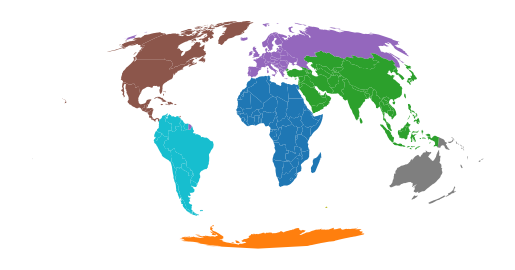

In [31]:
ax = world.plot(column='continent')
ax.set_axis_off()

There are slight inaccuracies in Continent Geometries (overlapping polygons), which can be fixed by a small buffer, before dissolving country geometries:

In [32]:
world['geometry'] = world.buffer(0.01)

In [33]:
continents = world.dissolve(by='continent')

In [34]:
continents.head()

geometry
continent                                                       
Africa         MULTIPOLYGON (((3935404.022 -844960.870, 39354...
Antarctica     MULTIPOLYGON (((-5823349.028 -8432831.992, -59...
Asia           MULTIPOLYGON (((12350738.789 -1251249.154, 123...
Europe         MULTIPOLYGON (((-5168883.074 513724.090, -5168...
North America  MULTIPOLYGON (((-7697776.465 1070494.583, -769...

Assign index back as a column, to classify via color by `column='continent'`

In [35]:
continents['continent'] = continents.index.get_level_values(0)

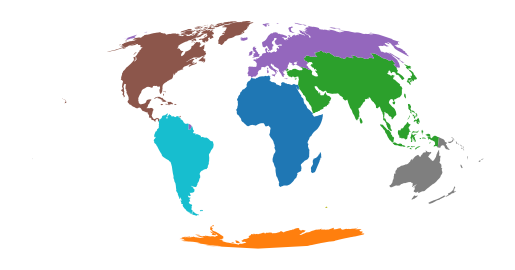

In [36]:
ax = continents.plot(column='continent')
ax.set_axis_off()

### Create a GeoDataFrame from HLL coordinates

In [37]:
gdf = gp.GeoDataFrame(
    df, geometry=gp.points_from_xy(df.longitude, df.latitude))
gdf.crs=CRS_WGS
gdf = gdf.to_crs(CRS_PROJ)

Define pyproj Transformer ahead of time with xy-order of coordinates, for future projections between WGS1984 and EPSG 54009 (Mollweide)

In [38]:
PROJ_TRANSFORMER = Transformer.from_crs(
    CRS_WGS, CRS_PROJ, always_xy=True)
# also define reverse projection
PROJ_TRANSFORMER_BACK = Transformer.from_crs(
    CRS_PROJ, CRS_WGS, always_xy=True)

In [39]:
gdf.set_index(['latitude', 'longitude'], inplace=True)

In [40]:
gdf.head()

user_hll  \
latitude  longitude                                                        
 0.040050 -179.750586  \x138b400e0116e13ec2414152615441a6a1b206c544e3...   
-0.364335 -179.752800                                       \x138b40cbe1   
-0.768727 -179.760539                                       \x138b407ee3   
 0.848830 -177.767038                                       \x138b406641   
-0.364335 -177.757221                                       \x138b4039c1   

                                               geometry  
latitude  longitude                                      
 0.040050 -179.750586    POINT (-18015096.000 4952.000)  
-0.364335 -179.752800  POINT (-18015096.000 -45048.000)  
-0.768727 -179.760539  POINT (-18015096.000 -95048.000)  
 0.848830 -177.767038  POINT (-17815096.000 104952.000)  
-0.364335 -177.757221  POINT (-17815096.000 -45048.000)

### Calculate Cardinality

Define a preview area (Italy)

In [41]:
bbox_eu = (
    6.8662109375, 35.24427318493909,
    22.31396484375, 45.29320031385282)
# create bounds from WGS1984 italy and project to Mollweide
minx, miny = PROJ_TRANSFORMER.transform(
    bbox_eu[0], bbox_eu[1])
maxx, maxy = PROJ_TRANSFORMER.transform(
    bbox_eu[2], bbox_eu[3])

In [42]:
gdf_italy = gdf.cx[minx:maxx, miny:maxy]

In [43]:
%%time
cardinality_series = tools.hll_series_cardinality(gdf_italy["user_hll"], db_conn=DB_CALC)

CPU times: user 5.4 ms, sys: 7.84 ms, total: 13.2 ms
Wall time: 36.7 ms


In [44]:
cardinality_series.head()

latitude   longitude
45.135626  7.872342     11178
44.675021  7.832822      2867
44.215775  7.794253      2090
43.757857  7.756606      4969
43.301242  7.719851        31
Name: user_hll, dtype: int64

In [45]:
gdf.loc[
    cardinality_series.index,
    "usercount"] = cardinality_series

Preview HLL coordinates and cardinality:

In [46]:
fig, ax = plt.subplots(1, 1)

ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

plot_kwd = {
    'column':'usercount',
    'legend':True, 
    'markersize':25,
    'cmap':'Reds', 
    'scheme':'quantiles',
    'legend_kwds':{'bbox_to_anchor': (1, 1), 'frameon':False, 'markerscale':0.7}
    }
base = gdf.cx[minx:maxx, miny:maxy].plot(
    ax=ax, **plot_kwd)
world.plot(
    ax=base, color='none', edgecolor='black', linewidth=0.5)
ax.set_axis_off()

### Union HLL sets per continent

The last step is to union HLL sets per continent and calculate the combined cardinality.

In [47]:
%%time
gdf_overlay = gp.overlay(
    gdf, world, 
    how='intersection')
gdf_overlay.set_index("continent", inplace=True)

CPU times: user 44.7 s, sys: 188 ms, total: 44.9 s
Wall time: 44.9 s


In [48]:
gdf_overlay.head()

user_hll  usercount  \
continent                                                                  
Antarctica                                       \x138b40e142        NaN   
Antarctica  \x138b4004a41f81220330a132e4340135443a62446146...        NaN   
Antarctica                                       \x138b40d241        NaN   
Antarctica                                       \x138b40f601        NaN   
Antarctica                                       \x138b40adc4        NaN   

                                     geometry  
continent                                      
Antarctica        POINT (-0.000 -9020047.848)  
Antarctica        POINT (-0.000 -9020047.848)  
Antarctica        POINT (-0.000 -9020047.848)  
Antarctica  POINT (-5915096.000 -8345048.000)  
Antarctica  POINT (-5715096.000 -8145048.000)

In [49]:
%%time
cardinality_series = tools.union_hll_series(
    gdf_overlay["user_hll"], db_conn=DB_CALC, cardinality=True)

CPU times: user 123 ms, sys: 149 ms, total: 272 ms
Wall time: 1.64 s


Below we can see the combined count distinct of users on Flickr per continent.

In [50]:
cardinality_series.sort_values(ascending=False).head(10)

continent
Europe                     984220
North America              676036
Asia                       408161
South America              191955
Oceania                     87333
Africa                      75514
Antarctica                   1166
Seven seas (open ocean)        27
Name: hll_cardinality, dtype: int64

Assign cardinality back to continents Geodataframe

In [51]:
continents.loc[
    cardinality_series.index,
    "usercount"] = cardinality_series.values

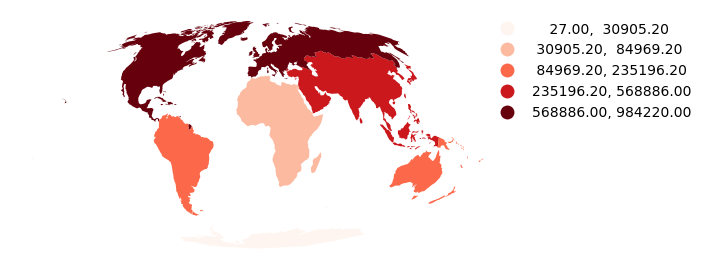

In [89]:
plot_kwd['legend_kwds'] = {'bbox_to_anchor': (1.4, 1), 'frameon':False}
ax = continents.plot(**plot_kwd)
ax.set_axis_off()

## Intersection example

It is also possible to intersect HLL sets, to some degree. This can be used to estimate common visitor counts for (e.g.) countries. The average error, however, will be larger, especially for intersections of HLL sets for different sizes.

In [53]:
world = gp.read_file(
    gp.datasets.get_path('naturalearth_lowres'),
    crs=CRS_WGS)
world = world.to_crs(
    CRS_PROJ)

Select geometry for DE, FR and UK

In [54]:
geom1 = world[world['name'] == "Germany"]
geom2 = world[world['name'] == "France"]
geom3 = world[world['name'] == "United Kingdom"]

<div class="alert alert-warning" role="alert" style="color: black;">
    <details><summary style="cursor: pointer;"><strong>Select different countries</strong></summary>
    <ul>
        <li>Optionally: Modify the list of countries to adapt visualizations below.</li>
    </ul>
Example:
<pre lang="python">
geom1 = world[world['name'] == "Germany"]
geom2 = world[world['name'] == "United States of America"]
geom3 = world[world['name'] == "Canada"]
</pre>
----
<pre lang="python">
ref_a = "de"
ref_b = "us"
ref_c = "ca"
name_ref = {
    ref_a:"Germany",
    ref_b:"USA",
    ref_c:"Canada"}
</pre>
    </details>
</div>

In [55]:
ref_a = "de"
ref_b = "fr"
ref_c = "uk"
name_ref = {
    ref_a:"Germany",
    ref_b:"France",
    ref_c:"United Kingdom"}

For visual purposes, for some countries, we want to filter continuous areas, e.g. mainland for the US, or mainland FR.

In [56]:
if ref_b == "us":
    geom2 = geom2.explode(index_parts=False).iloc[0:1].dissolve(by='name')

In [57]:
if ref_b == "fr":
    geom2 = geom2.explode(index_parts=False).iloc[1:].dissolve(by='name')

In [58]:
sel_colors=["#6d904f", "#008fd5", "#fc4f30"]

In [59]:
fig, ax = plt.subplots(1, 3)
for ix, subplot in enumerate([geom1, geom2, geom3]):
    subplot.plot(ax=ax[ix], color=sel_colors[ix])
    ax[ix].set_axis_off() 

### Select coordinates

Intersect hll coordinates with country geometry. Since hll coordinates are pre-aggregated (50 km), direct intersection will yield some error rate (in this case, called [MAUP](https://en.wikipedia.org/wiki/Modifiable_areal_unit_problem)).


In [60]:
from geopandas.tools import sjoin
gdf_intersect = sjoin(
        gdf, geom1, how='right')

In [61]:
hll_series = {
    }

Union all HLL sets for selected geometry.

In [62]:
hll_series[ref_a] = union_hll(gdf_intersect["user_hll"])

This is the unioned HLL set for all unique users on Flickr who shared at least one geotagged photo from Germany.

In [63]:
hll_series[ref_a]

'\\x148b4052cea314e75190739d683994e41d29425053a8e931d263a0c6318a629d274a0e63ad47499055a10831d0a4a0c742586320e82b50a69d073a50a4296741d48314c73a0c831ce639ca5338ca31d4942ca829d0651cc73acc85a0e951908614e7398e8318e8398e93290a39907319683a0c63a10749d075210842107328e8330a8318e7331083990539cc841d06418e851caa41d09294c6518c8320c649ce5324e639908315283190841ce63192d314c8425c6515074b1283b4cb3a547399a56a0a741d68320c7319074a0e5320c75192741ce7418e7324a94a8ca3a107618c8398e84bd07318eb420c7418cb4b0ab31d063b926318e732d264a5484190b3a8e63a0ec314e8315254a8eb414e649d093a107415673a9484a0c741d0839cc8320c83a0ab3a52631d04424a741d08320c6318ea41d093992539d2741ca93b0e7320cb2a4a7521073a4c7398c54b127419262a4c741d0751ce661cc639927428e8414ed4a0c8394e6494a7324e5430c6418e741ce741cc73212c424ec3ad063a0e842526420e631cc649ce639948320c53b0a7598c9299073a4e53a10e42ce6318e729d47531a64250661ca6424c749d473992631d4649d0831525320c639588394c65190a31caa3a0c84390739d0722ceb394e82b0e8320c539d0831ce53ad67299082a125424c7498a7398c931ca9320c7

.. an estimated number of:

In [64]:
cardinality_hll(hll_series[ref_a])

162575

Vice versa, we can "update" select original coordinates that intersect with selected geometries by using the index:

In [65]:
def get_selected_coords(gdf_intersect, gdf) -> gp.GeoDataFrame:
    """Return selected coordinates based on index"""
    gdf_intersect.set_index(
        ["index_left0", "index_left1"],
        inplace=True)
    return gdf.loc[gdf_intersect.index]

In [66]:
coords_ref_a = get_selected_coords(gdf_intersect, gdf)

Plot preview

In [67]:
minx, miny, maxx, maxy = gdf_intersect.total_bounds

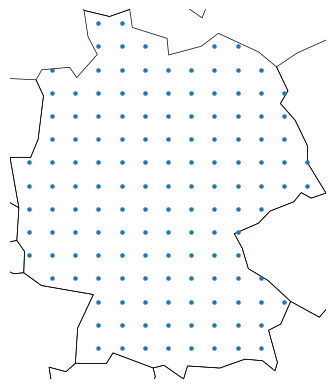

In [68]:
fig, ax = plt.subplots(1, 1)
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
base = world.plot(
    ax=ax, color='none', edgecolor='black', linewidth=0.5)
layers = coords_ref_a.plot(ax=base, markersize=5)
layers.set_axis_off()

Repeat for the other two countries

In [69]:
gdf_intersect = sjoin(
        gdf, geom2, how='right')
hll_series[ref_b] = union_hll(gdf_intersect["user_hll"])
coords_ref_b = get_selected_coords(gdf_intersect, gdf)

In [70]:
gdf_intersect = sjoin(
        gdf, geom3, how='right')
hll_series[ref_c] = union_hll(gdf_intersect["user_hll"])
coords_ref_c = get_selected_coords(gdf_intersect, gdf)

Return distinct errors with error margin (±2.3%)

In [71]:
for ref, hll_set in hll_series.items():
    cardinality = cardinality_hll(hll_set)
    print(f'Estimated {cardinality} (±{int(cardinality/100*2.3)}) users for {name_ref.get(ref)}')

Estimated 162575 (±3739) users for Germany
Estimated 216482 (±4979) users for France
Estimated 300156 (±6903) users for United Kingdom


### Plot preview

Get the total bounds:

In [72]:
minx, miny, maxx, maxy = pd.concat(
    [coords_ref_a["geometry"], coords_ref_b["geometry"], coords_ref_c["geometry"]]).total_bounds

In [73]:
from typing import List, Optional
def plot_map(
    gdf: gp.GeoDataFrame, sel_coords: List[gp.GeoDataFrame],
    sel_colors: List[str], buf = 100000,
    title: Optional[str] = None, ax = None):
    """Plot GeoDataFrame with matplotlib backend, optionaly export as png"""
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(5, 10))
    ax.set_xlim(minx-buf, maxx+buf)
    ax.set_ylim(miny-buf, maxy+buf)
    if title:
        ax.set_title(title, fontsize=12)
    for ix, sel_coord in enumerate(sel_coords):
        sel_coord.plot(
            ax=ax,
            color=sel_colors[ix],
            alpha=1.0,
            markersize=10)
    gdf.plot(
        ax=ax, 
        alpha=0.2,
        markersize=0.1)
    # combine with world geometry
    world.plot(
        ax=ax, color='none', edgecolor='black', linewidth=0.3)
    # ax.imshow(fig, interpolation='nearest', cmap='gray')
    # turn axis off
    ax.set_axis_off()

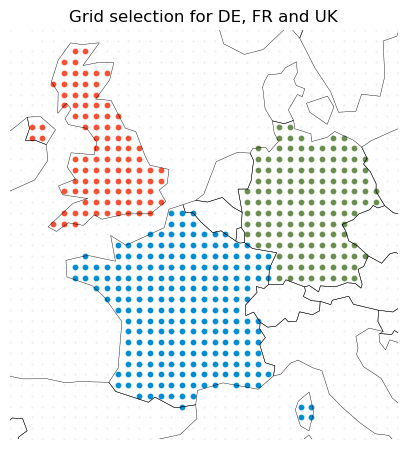

In [74]:
sel_coords=[coords_ref_a, coords_ref_b, coords_ref_c]
plot_map(
    gdf=gdf, sel_coords=sel_coords, 
    sel_colors=sel_colors,
    title=f'Grid selection for {ref_a.upper()}, {ref_b.upper()} and {ref_c.upper()}')

### Calculate hll intersection (common visitors)

According to the [Union-intersection-principle](https://en.wikipedia.org/wiki/Inclusion%E2%80%93exclusion_principle):

$|A \cup B| = |A| + |B| - |A \cap B|$

which can also be written as:

$|A \cap B| = |A| + |B| - |A \cup B|$

Therefore, unions can be used to calculate intersection. Calculate $|DE \cup US|$, $|DE \cup CA|$ and $|US \cup CA|$, i.e.:
```python
IntersectionCount = 
cardinality_hll(de)::int +
cardinality_hll(us)::int - 
cardinality_hll(hll_union(de, us)
```

In [75]:
distinct_users_total = {}
distinct_users_total[ref_a] = cardinality_hll(hll_series[ref_a])
distinct_users_total[ref_b] = cardinality_hll(hll_series[ref_b])
distinct_users_total[ref_c] = cardinality_hll(hll_series[ref_c])
distinct_users_total

{'de': 162575, 'fr': 216482, 'uk': 300156}

In [76]:
union_p1 = (hll_series[ref_a], hll_series[ref_b])
union_p2 = (hll_series[ref_a], hll_series[ref_c])
union_p3 = (hll_series[ref_b], hll_series[ref_c])

First, prepare combination for different sets.

In [77]:
hll_sel = {
    f"{ref_a}-{ref_b}": union_p1,
    f"{ref_a}-{ref_c}": union_p2,
    f"{ref_b}-{ref_c}": union_p3
}
distinct_common = {}
for int_tuple, hll_sets in hll_sel.items():
    hll_set = union_hll(
        [hll_sets[0], hll_sets[1]])
    distinct_common[int_tuple] = cardinality_hll(hll_set)
    print(
        f"{distinct_common[int_tuple]} distinct total users "
        f"who shared Flickr photos from either {name_ref.get(int_tuple.split('-')[0])} "
        f"or {name_ref.get(int_tuple.split('-')[1])} (union)")

318865 distinct total users who shared Flickr photos from either Germany or France (union)
427599 distinct total users who shared Flickr photos from either Germany or United Kingdom (union)
452797 distinct total users who shared Flickr photos from either France or United Kingdom (union)


Calculate intersection

In [78]:
distinct_intersection = {}
for a, b in [(ref_a, ref_b), (ref_a, ref_c), (ref_b, ref_c)]:
    a_total = distinct_users_total.get(a)
    b_total = distinct_users_total.get(b)
    common_ref = f'{a}-{b}'
    intersection_count = a_total + b_total - distinct_common.get(common_ref)
    distinct_intersection[common_ref] = intersection_count
    print(
        f"{distinct_intersection[common_ref]} distinct users "
        f"who shared Flickr photos from {name_ref.get(a)} and {name_ref.get(b)} (intersection)")

60192 distinct users who shared Flickr photos from Germany and France (intersection)
35132 distinct users who shared Flickr photos from Germany and United Kingdom (intersection)
63841 distinct users who shared Flickr photos from France and United Kingdom (intersection)


Finally, lets get the number of users who have shared pictures from all three countries, based on the [formula for three sets](https://en.wikipedia.org/wiki/Inclusion%E2%80%93exclusion_principle):

$|A \cup B \cup C| = |A| + |B| + |C| - |A \cap B| - |A \cap C| - |B \cap C| + |A \cap B \cap C|$

which can also be written as:

$|A \cap B \cap C| = |A \cup B \cup C| - |A| - |B| - |C| + |A \cap B| + |A \cap C| + |B \cap C|$

In [79]:
union_count_all = cardinality_hll(union_hll(
    [hll_series[ref_a], hll_series[ref_b], hll_series[ref_c]]))
union_count_all

547691

In [80]:
intersection_count_all = union_count_all - \
    distinct_users_total[ref_a] - \
    distinct_users_total[ref_b] - \
    distinct_users_total[ref_c] + \
    distinct_intersection[f'{ref_a}-{ref_b}'] + \
    distinct_intersection[f'{ref_a}-{ref_c}'] + \
    distinct_intersection[f'{ref_b}-{ref_c}']
    
print(intersection_count_all)

27643


Since negative visitor counts are impossible, the increasing inaccuracies for nested intersections are easily observable here. In other words, there is simply too little overlap between the visitors between all three countries to be measurable with HLL intersections

## Visualize as Venn diagram

Since we're going to visualize this with [matplotlib-venn](https://github.com/konstantint/matplotlib-venn), we need the following variables:

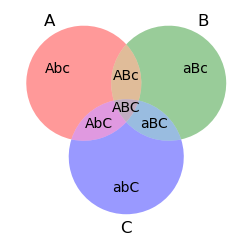

In [81]:
from matplotlib_venn import venn3, venn3_circles
plt.figure(figsize=(3,3))
v = venn3(
    subsets=(
        500,
        500, 
        100,
        500,
        100,
        100,
        10),
    set_labels = ('A', 'B', 'C'))
v.get_label_by_id('100').set_text('Abc')
v.get_label_by_id('010').set_text('aBc')
v.get_label_by_id('001').set_text('abC')
v.get_label_by_id('110').set_text('ABc')
v.get_label_by_id('101').set_text('AbC')
v.get_label_by_id('011').set_text('aBC')
v.get_label_by_id('111').set_text('ABC')
plt.show()

We already have `ABC`, the other values can be calculated:

In [82]:
ABC = intersection_count_all
ABc = distinct_intersection[f'{ref_a}-{ref_b}'] - ABC
aBC = distinct_intersection[f'{ref_b}-{ref_c}'] - ABC
AbC = distinct_intersection[f'{ref_a}-{ref_c}'] - ABC
Abc = distinct_users_total[ref_a] - ABc - AbC + ABC
aBc = distinct_users_total[ref_b] - ABc - aBC + ABC
abC = distinct_users_total[ref_c] - aBC - AbC + ABC

Define Function to plot Venn Diagram.

In [83]:
from typing import Tuple

def plot_venn(
    subset_sizes: List[int],
    colors: List[str], 
    names: List[str],
    subset_sizes_raw: List[int] = None,
    ax = None,
    title: str = None):
    """Plot Venn Diagram"""
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(5,5))
    set_labels = (
        'A', 'B', 'C')
    v = venn3(
        subsets=(
            [subset_size for subset_size in subset_sizes]),
        set_labels = set_labels,
        ax=ax)    
    for ix, idx in enumerate(
        ['100', '010', '001']):
        v.get_patch_by_id(
            idx).set_color(colors[ix])
        v.get_patch_by_id(
            idx).set_alpha(0.8)
        v.get_label_by_id(
            set_labels[ix]).set_text(
            names[ix])
    if subset_sizes_raw:
        for ix, idx in enumerate(
            ['100', '010', None, '001']):
            if not idx:
                continue
            dif_abs = subset_sizes[ix] - subset_sizes_raw[ix]
            dif_perc = dif_abs / (subset_sizes_raw[ix] / 100)
            v.get_label_by_id(idx).set_text(
                f'{subset_sizes[ix]}\n{dif_perc:+.1f}%')            
    label_ids = [
        '100', '010', '001',
        '110', '101', '011',
        '111', 'A', 'B', 'C']
    for label_id in label_ids:
        v.get_label_by_id(
            label_id).set_fontsize(14)
    # draw borders
    c = venn3_circles(
        subsets=(
            [subset_size for subset_size in subset_sizes]),
        linestyle='dashed',
        lw=1,
        ax=ax)
    if title:
        ax.title.set_text(title)

Plot Venn Diagram:

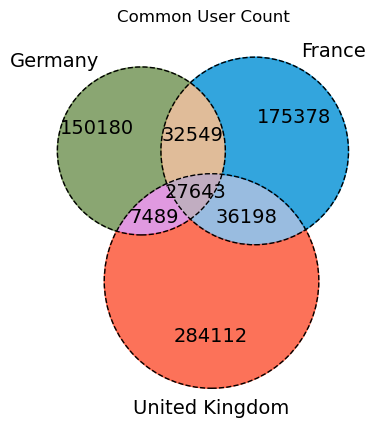

In [84]:
subset_sizes = [
    Abc, aBc, ABc, abC, AbC, aBC, ABC]
names = [
    name_ref.get(ref_a), name_ref.get(ref_b), name_ref.get(ref_c)]
plot_venn(
    subset_sizes=subset_sizes,
    colors=sel_colors,
    names=names,
    title="Common User Count")

### Combine Map & Venn Diagram

A figure with two subplots (1 row, 2 columns).

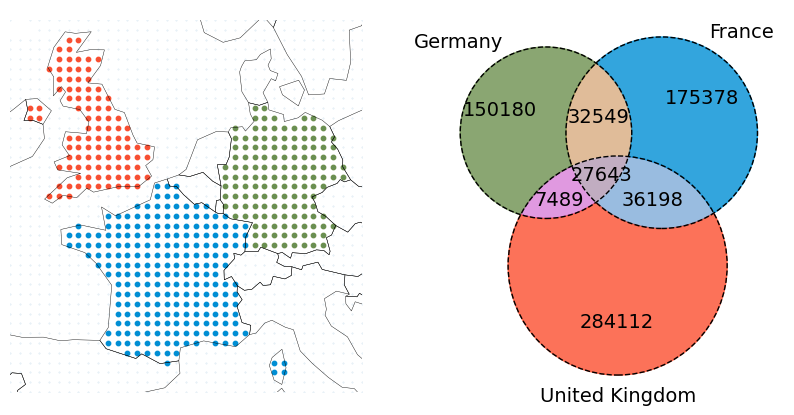

In [93]:
fig, ax = plt.subplots(1, 2, figsize=(10, 15), width_ratios=[1, 1])
plot_map(
    gdf=gdf, sel_coords=sel_coords, 
    sel_colors=sel_colors, ax=ax[0])
plot_venn(
    subset_sizes=subset_sizes,
    colors=sel_colors,
    names=names,
    ax=ax[1])
# store as png
fig.savefig(
    Path.cwd().parents[0] / "resources" / f"hll_intersection_{ref_a}{ref_b}{ref_c}.png", dpi=300, format='PNG',
    bbox_inches='tight', pad_inches=0)

Each dot on the left side is a coordinate shared in the original dataset, with an attached HLL set abstracting all users having shared photographs from this part of the world. By union of all HLL sets for each of the three country, based on coordinate-country inersection, we were able to calculate the intersection between different sets. These estimated common visitor counts are labeled on the right side in the Venn diagram. 

The number of distinct users who shared photos from UK outweighs Germany and France.There is a slightly larger overlap between common visitors for France and UK. By union of HLL sets, we are able to estimate distinct visitor counts for arbitrary areas or regions. This ability to re-use HLL sets is, however, limited by the lower limit of 50km resolution of the shared benchmark dataset.

## Create notebook HTML

In [96]:
!jupyter nbconvert --to html_toc \
    --output-dir=../resources/html/ ./intro.ipynb \
    --template=../nbconvert.tpl \
    --ExtractOutputPreprocessor.enabled=False >&- 2>&-